# Frac Production Analysis

This is a continuation of the Frac Production Data Cleaning notebook.

Here I will explore and analyze the data to identify features to use for modeling.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
from scipy.stats import pearsonr, spearmanr, linregress
from scipy.stats import shapiro, mannwhitneyu, kruskal
from statsmodels.graphics.gofplots import qqplot

from sklearn.linear_model import LinearRegression

## Importing Data

In [2]:
# Read in the cleaned colorado data
cofrac = pd.read_csv('fracwells_co.csv', index_col=0)
cofrac.head()

,CumBOE,CumGas,CumOil,DrillType,Field,First6BOE,FirstProdDate,GrossPerforatedInterval,HorizontalLength,LowerPerforation,...,Township,TreatmentJobCount,UpperPerforation,VerticalDepth,WellName,WellNumber,gel,sandmass,slick,xlinkgel
5001098010000,188242.0,273498.0,142659.0,H,WATTENBERG,46241.0,2015-01-01,NaN,2247.84,NaN,...,01S,1.0,NaN,7774.00,SHARP,24-3-11HC,0.0,2.533881e+06,1.0,1.0
5001097850000,22828.0,39256.0,16285.0,H,THIRD CREEK,7094.0,2014-06-01,NaN,4499.09,NaN,...,01S,1.0,NaN,7576.73,STATE OF CO,1S-66-36-1609CH,0.0,3.274332e+06,1.0,1.0
5001097830000,23909.0,44706.0,16458.0,H,THIRD CREEK,8304.0,2014-06-01,NaN,4556.06,NaN,...,01S,1.0,NaN,7511.68,STATE OF CO,1S-66-36-0108BH,0.0,3.045143e+06,1.0,1.0
5001097820000,21407.0,45118.0,13887.0,H,WATTENBERG,7118.0,2014-06-01,NaN,4525.40,NaN,...,01S,1.0,NaN,7574.72,STATE OF CO,1S-66-36-0108CH,0.0,2.784211e+06,1.0,1.0
5001097810000,31084.0,65779.0,20121.0,H,THIRD CREEK,10385.0,2014-06-01,NaN,4504.51,NaN,...,01S,1.0,NaN,7513.70,STATE OF CO,1S-66-36-1609BH,0.0,3.056162e+06,1.0,1.0


In [3]:
cofrac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4538 entries, 5001098010000 to 5005071970000
Data columns (total 24 columns):
CumBOE                     4538 non-null float64
CumGas                     4538 non-null float64
CumOil                     4538 non-null float64
DrillType                  4538 non-null object
Field                      4538 non-null object
First6BOE                  4538 non-null float64
FirstProdDate              4538 non-null object
GrossPerforatedInterval    3721 non-null float64
HorizontalLength           4537 non-null float64
LowerPerforation           3721 non-null float64
OperatorAlias              4538 non-null object
Range                      4538 non-null object
TargetFormation            4538 non-null object
TotalDepth                 4530 non-null float64
Township                   4538 non-null object
TreatmentJobCount          4537 non-null float64
UpperPerforation           3721 non-null float64
VerticalDepth              4528 non-null float

Let's first see how many different values each column has. 

In [4]:
cofrac.nunique()

CumBOE                     4494
CumGas                     4531
CumOil                     4473
DrillType                     1
Field                        15
First6BOE                  4428
FirstProdDate                72
GrossPerforatedInterval    2435
HorizontalLength           4503
LowerPerforation           2807
OperatorAlias                25
Range                        12
TargetFormation              17
TotalDepth                 3172
Township                     13
TreatmentJobCount             5
UpperPerforation           1662
VerticalDepth              2429
WellName                    720
WellNumber                 3961
gel                           2
sandmass                   3869
slick                         2
xlinkgel                      2
dtype: int64

Looks like there are 25 different operators in this data set, with 17 different target formations, and 13 Townships and 12 Ranges. I will further investigate these different values, along with the distributions of the continuous variables.

The following columns are more for identification rather than to act as potential features for modeling: Well Name, Well Number, First Production Date and probably Field, as that will change from state to state.

I'll start with the categorical variables in case they need further cleaning.

### Data Cleaning
#### Field

In [5]:
cofrac.Field.value_counts()

WATTENBERG                        3858
DJ HORIZONTAL NIOBRARA             463
WILDCAT                            163
SEVERANCE                           10
HEREFORD                             8
EATON                                7
DJ HORIZONTAL CODELL                 6
SPINDLE                              5
NORTH RIVERSIDE                      4
THIRD CREEK                          4
DJ HORIZONTAL CODELL-FORT HAYS       3
RIVERSIDE                            3
NE RIVERSIDE II                      2
GREELEY                              1
MASTERS                              1
Name: Field, dtype: int64

Wow, it looks like the Wattenberg field is the most common field drilled in this data set. I might want to combine some of these fields in the future, or just use the Wattenberg field.

#### Township and Range

In [6]:
cofrac.Range.value_counts()

67W    790
66W    717
65W    700
68W    455
63W    447
64W    382
62W    372
58W    335
59W    126
61W     98
57W     71
60W     45
Name: Range, dtype: int64

It looks like these are fairly well distributed across the ranges, with a couple of exceptions, large and small.

In [7]:
cofrac.Township.value_counts()

06N    796
02N    779
05N    741
03N    495
04N    444
01N    435
09N    325
N      246
07N    196
08N     34
01S     22
04S     17
05S      8
Name: Township, dtype: int64

Interesting, there are a significant number of unlabeled townships, with just the direction, north. After looking at all of the API numbers of wells with "N" townships, they all come from Weld County, where townships include 10N, 11N, and 12N. I will re-code these as 10+.

In [8]:
cofrac.Township = cofrac.Township.map(lambda x: '10+N' if x == 'N' else x)

Now that the townships and ranges are all cleaned up, they really go together to designate a single plot, so should not be individual variables.  I will concatenate them together. 

In [9]:
cofrac['TR'] = cofrac.Township + cofrac.Range
cofrac[['TR','Township','Range']].head()

,TR,Township,Range
5001098010000,01S67W,01S,67W
5001097850000,01S66W,01S,66W
5001097830000,01S66W,01S,66W
5001097820000,01S66W,01S,66W
5001097810000,01S66W,01S,66W


In [10]:
cofrac.TR.nunique()

78

#### Target Formation
Next, let's take a look at the different target formations.  This will tell us the type of rock that the well is targeting and should be important in the amount of production of the well. 

In [11]:
cofrac.TargetFormation.value_counts()

NIOBRARA                             3422
CODELL                                724
CODELL-FORT HAYS                      119
CODELL-FORT HAYS-NIOBRARA              89
CARLILE-CODELL-FORT HAYS               61
CARLILE-CODELL-FORT HAYS-NIOBRARA      52
CODELL-CARLILE                         27
CODELL-NIOBRARA                        10
FORT HAYS-NIOBRARA                      9
FORT HAYS                               6
GREENHORN                               5
SUSSEX                                  4
NIOBRARA-SHARON SPRINGS                 4
NOT COMPLETED (NIOBRARA )               2
J SAND                                  2
NOT COMPLETED (UNKNOWN)                 1
COGCC FORMATION CODE: NBCDCL            1
Name: TargetFormation, dtype: int64

The majority of wells targeted the Niobrara formation or Codell formation.  According to industry professionals, the only two oil and gas producing formations are Niobrara and Codell, so the target formations listed with multiple different formations should really just be the deepest formation.  The formations from top to bottom are: Niobrara, Fort Hays, Codell, and Carlisle. I will recode these as such.


In [12]:
cofrac.TargetFormation = cofrac.TargetFormation.map(lambda x: str(x))
cofrac.TargetFormation = cofrac.TargetFormation.map(lambda x: 'CODELL' if re.search('CODELL|CD', x) else x)
cofrac.TargetFormation = cofrac.TargetFormation.map(lambda x: 'NIOBRARA' if re.search('NIOBRARA', x) else x)
cofrac.TargetFormation = cofrac.TargetFormation.map(lambda x: x if re.search('CODELL|NIOBRARA', x) else 'OTHER')
cofrac.TargetFormation.value_counts()

NIOBRARA    3437
CODELL      1083
OTHER         18
Name: TargetFormation, dtype: int64

#### Continuous Variables

Now let's check the continuous variables.

In [13]:
cofrac.describe()

,CumBOE,CumGas,CumOil,First6BOE,GrossPerforatedInterval,HorizontalLength,LowerPerforation,TotalDepth,TreatmentJobCount,UpperPerforation,VerticalDepth,gel,sandmass,slick,xlinkgel
count,4538.000000,4.538000e+03,4538.000000,4538.000000,3721.000000,4537.000000,3721.000000,4530.000000,4537.000000,3721.000000,4528.000000,4538.000000,4.536000e+03,4538.000000,4538.000000
mean,155652.576906,4.159816e+05,86322.269502,58797.261569,5548.163397,6206.319647,12942.453104,13102.184004,1.256116,7394.289707,6866.937462,0.028427,4.758830e+06,0.982371,0.694579
std,84577.596588,3.117272e+05,44703.873841,29499.100896,2073.838815,2260.458353,2149.463265,2275.965619,0.482131,649.687097,549.168803,0.166207,4.171596e+06,0.131613,0.460636
min,402.000000,6.350000e+02,296.000000,137.000000,151.000000,43.670000,6870.000000,5976.000000,1.000000,248.000000,4782.000000,0.000000,4.037747e+01,0.000000,0.000000
25%,95798.250000,1.810475e+05,55822.750000,38573.750000,4026.000000,4516.760000,11416.000000,11467.250000,1.000000,7095.000000,6553.000000,0.000000,3.083189e+06,1.000000,0.000000
50%,139843.500000,3.257650e+05,77066.000000,54377.500000,4622.000000,5048.820000,12230.000000,12321.000000,1.000000,7520.000000,7008.000000,0.000000,3.705016e+06,1.000000,1.000000
75%,195962.000000,5.783025e+05,107364.500000,72684.250000,6805.000000,7725.540000,14247.000000,14532.750000,1.000000,7766.000000,7250.000000,0.000000,5.375082e+06,1.000000,1.000000
max,677112.000000,2.716674e+06,356272.000000,236728.000000,15982.000000,15009.750000,21986.000000,22086.000000,5.000000,16864.000000,9793.000000,1.000000,1.681255e+08,1.000000,1.000000


There is definitely a large spread in production, hopefully I can extract why this might be! 

There are still missing values in the perforation information, and a couple in total depth and vertical depth.  I will analyze these variables to determine if it is worth keeping or imputing these values before moving on. 

There are very few 0-values in this set, aside from the binary types of frac method. Let's see what these look like in more detail.

## Exploratory Data Analysis
### Production - First 6 Months BOE
First, let's take a look at the distribution of our target variable, First 6 months BOE or barrels of oil equivalencies.  This will tell us how we will need to compare the other distributions if this is normally distributed or not.

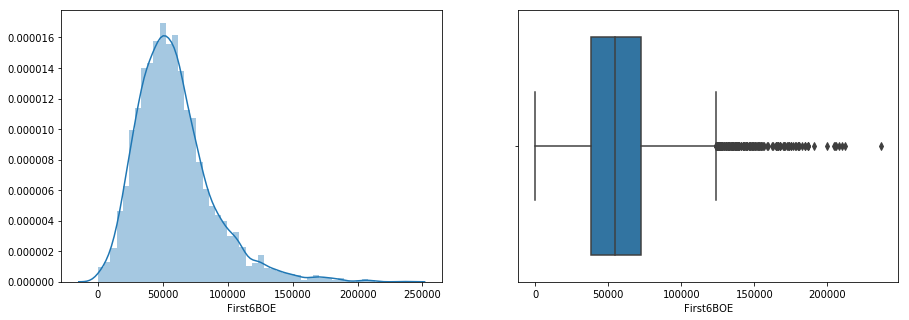

Shapiro-Wilk test for Normality:
W: 0.931554913520813
p-value:1.8572809846161125e-41


In [14]:
# Plotting the distribution of First 6 month's BOE
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(cofrac.First6BOE)
plt.subplot(122)
sns.boxplot(cofrac.First6BOE)
plt.show()

w, p = shapiro(cofrac.First6BOE)
print('Shapiro-Wilk test for Normality:\nW: {}\np-value:{}'.format(w, p))

It appears that the distribution of the first six months of production is skewed to the right with the median just above 50K BOE and a good amount of outliers above 150K BOE.  Also, according to the Shapiro-Wilk test for normality, we can reject that the distribution is approximately normally distributed.  

### Distributions
To investigate whether the columns are correlated with higher production, I will graph both the distribution of the individual column data along with its distribution relative to first 6 month's BOE.

In [15]:
# Isolating columns to examine and removing identifiers
cofrac_red = cofrac[['First6BOE', 'Field','GrossPerforatedInterval','HorizontalLength', 'LowerPerforation',
                     'TargetFormation','TotalDepth', 'TreatmentJobCount', 'TR', 'UpperPerforation', 'VerticalDepth',
                    'gel', 'sandmass','slick', 'xlinkgel']]

Field


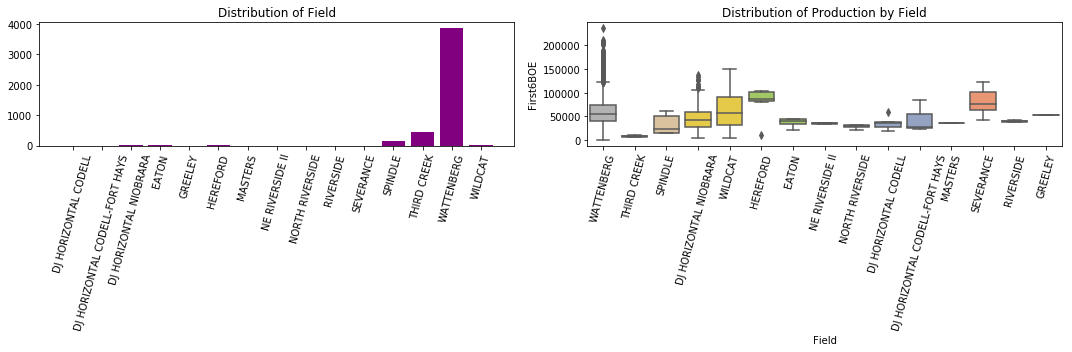

GrossPerforatedInterval


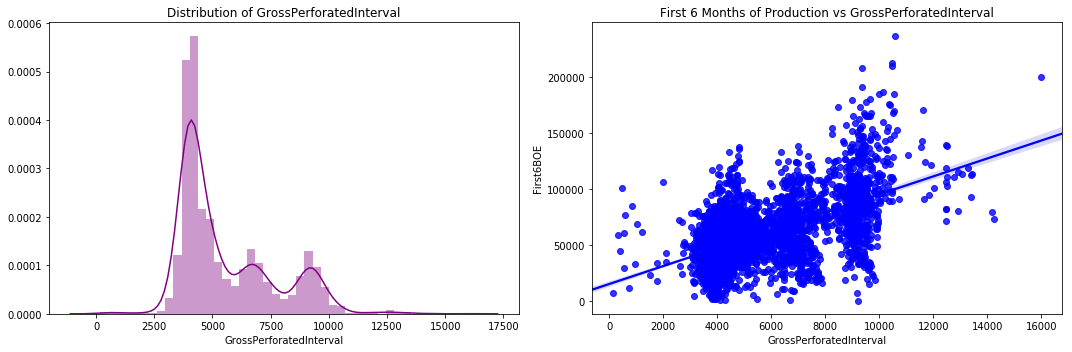

HorizontalLength


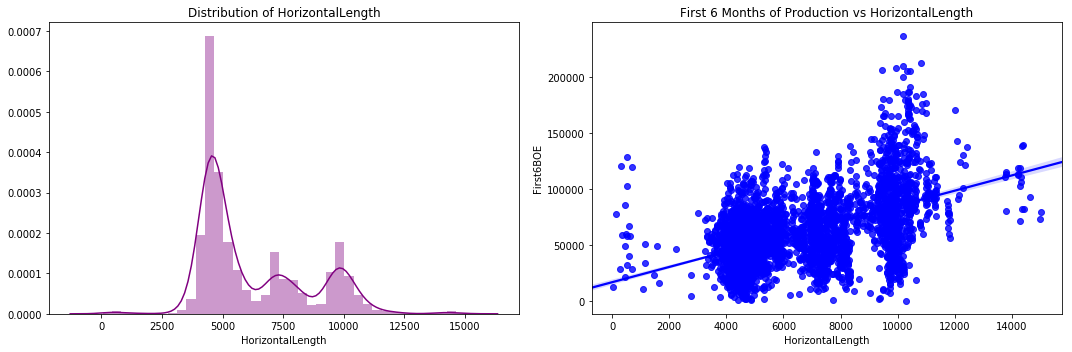

LowerPerforation


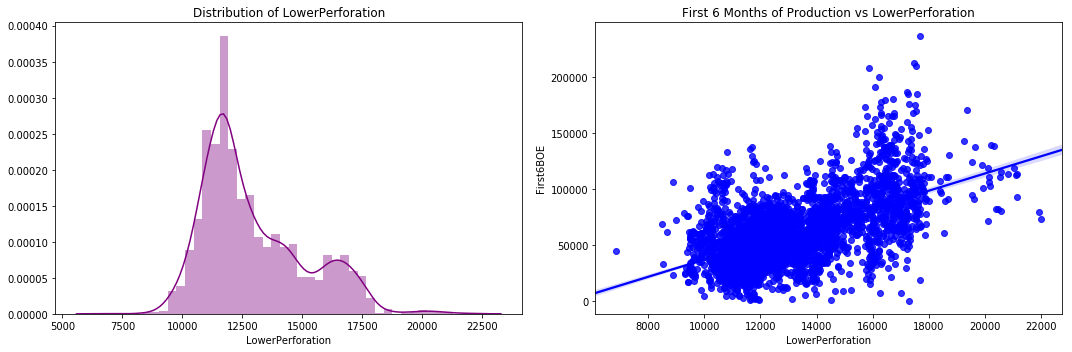

TargetFormation


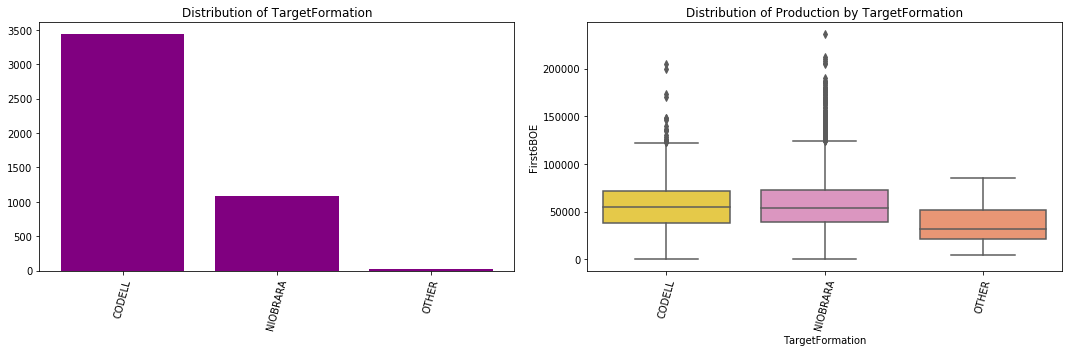

TotalDepth


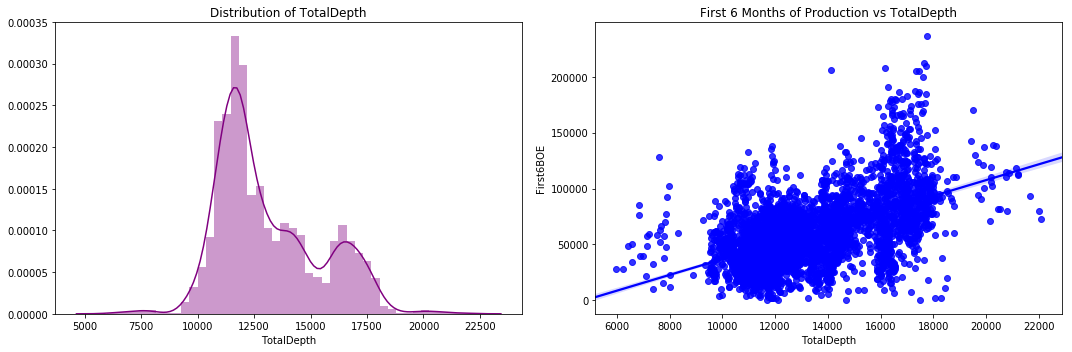

TreatmentJobCount


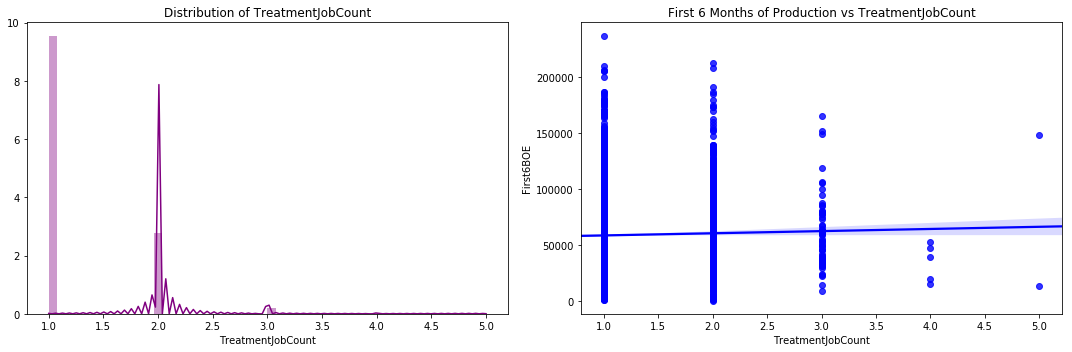

TR


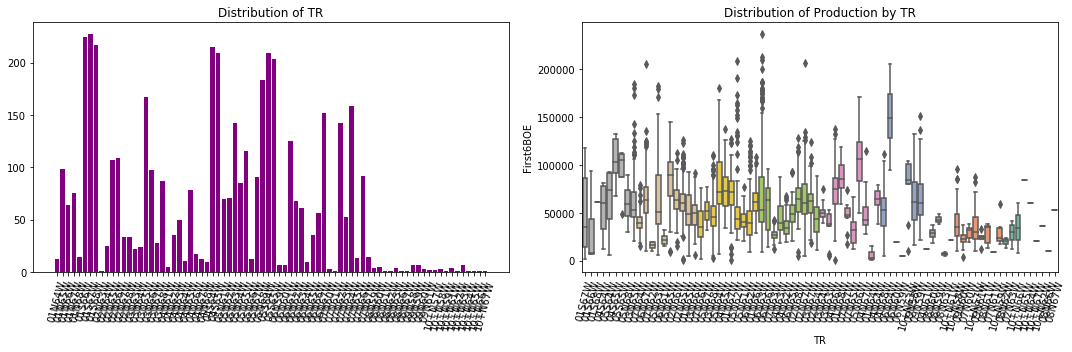

UpperPerforation


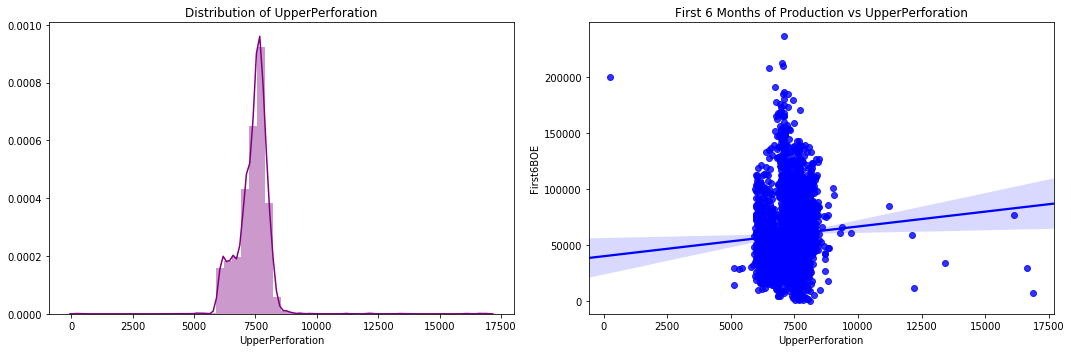

VerticalDepth


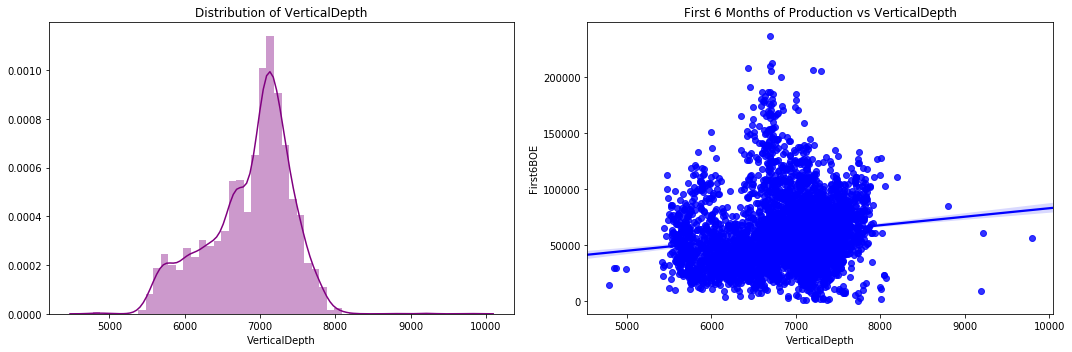

gel


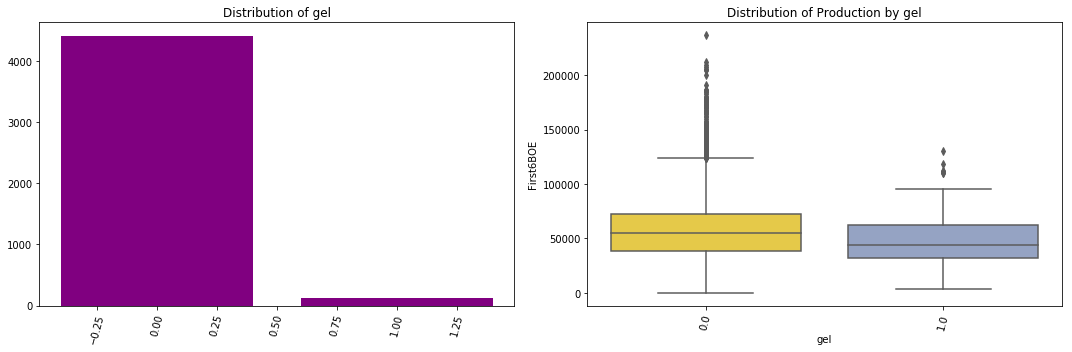

sandmass


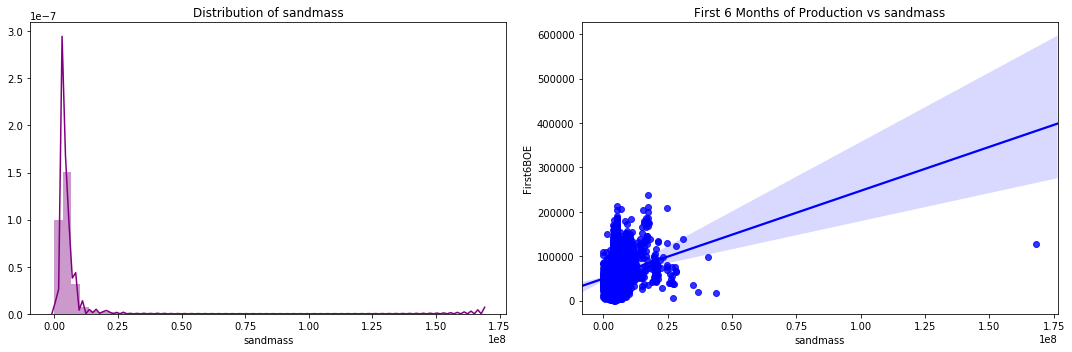

slick


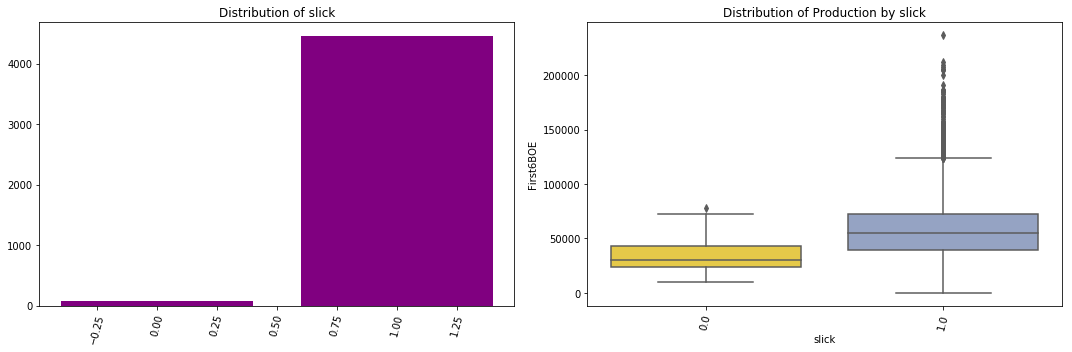

xlinkgel


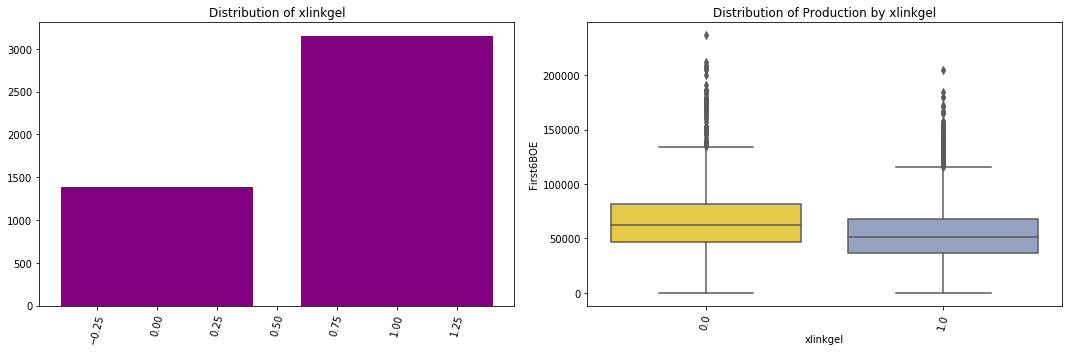

In [16]:
# Creating plots for each column except First 6 BOE
for col in cofrac_red.columns.drop('First6BOE'):
    print(col)
    if col in cofrac_red.select_dtypes(include='object').columns or col in ['gel','slick','xlinkgel']:
        # Plotting distributions of each column
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        temp = cofrac_red[[col, 'First6BOE']]
        temp = temp.dropna()
        plt.bar(temp[col].unique(), height=temp[col].value_counts(), color='Purple')
        plt.xticks(rotation=75)
        plt.title('Distribution of {}'.format(col))
    
        # Plotting distributions of each column by first 6 months production
        plt.subplot(122)
        g = sns.boxplot(y='First6BOE', x=col, data=temp, palette='Set2_r')
        plt.xticks(rotation=75)
        plt.title('Distribution of Production by {}'.format(col))
    
        plt.tight_layout()
        plt.show()
    elif col in cofrac_red.select_dtypes(include=['int64','float64']).columns.drop(['gel','slick','xlinkgel']):
        # Plotting distributions of each column
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        sns.distplot(cofrac_red[col].dropna(axis=0), color='Purple')
        plt.title('Distribution of {}'.format(col))
        
        # Plotting scatter plot of each column by production
        plt.subplot(122)
        #temp = cofrac_red[[col, 'First6BOE']]
        #temp = temp.dropna()
        sns.regplot(x=cofrac_red[col], y=cofrac_red['First6BOE'], color='Blue')
        plt.title('First 6 Months of Production vs {}'.format(col))
        
        plt.tight_layout()
        plt.show()
    
        

Insights from these visualizations:
- The Wattenberg __field__ does have the greatest number of wells drilled in it, and the next two most common fields have durastically different production distributions. __I will continue my analysis with only the Wattenberg field.__
- __Gross perforated interval__ has a trimodal distribution, with peaks between 2500-5000, 5000-8000, and 8000-11000.  While the regplot looks like there is a positive correlation between increased perforation intervals, and production, I think this variable might be better __binned into three groups__.
- __Horizontal length__ also has a trimodal distribution, with peaks between 2500-6000, 6000-9000, and 9000-12000 ft. These are typically 1 mile, 1.5 mile, or 2 mile targets.  I will also __put these lengths into three groups__, accordingly.
- __Lower perforation__ is non-normally distributed, so I will need to __identify some transformations to normalize this variable__, but again, it appears that the deeper the lower perforation, the larger the production.
- The Niobrara and Codell __Target Formations__ have a higher production than all other formations.
- __Total depth__ appears it could be a bimodal or trimodal distribution, but this is not as clearly delineated.  I again will need to __identify some transformations to normalize this variable__.  I also might want to consider combining some of the depth variables into one.
- __Treatment job count__ is mostly centered at 1, and doesn't appear to have any correlation to production.  I will check the p-value on this, but I will likely __drop treatment job count__ from the data set.
- The __Townships and ranges__ are all over the place in terms of production.  This variable might be helpful in interpreting the results, but not helpful in modeling.
- __Upper perforation__ looks approximately normally distributed, with a slight hump to the left.  I want to see what the __difference between upper and lower perforations__ would look like against the production.
- __Vertical depth__ also has a slight hump to the left at shallower depths, and the production increases slightly with increased depth.  This could be because of its traversal into better formations too, so that's something to look out for in terms of independence.
- The __non-cross-linked gel__ method of fracing is not used very often, and not using linear gel appears to have a slightly higher distribution of production.  I will need to check the p-value on this distribution.
- __Sand mass__ has a significant outlier at 1.7x10^8 lbs of sand, and the distribution looks like it's slightly skewed to the right even without that.  I will need to normalize this distribution and investigate that large sand use well.
- The __slickwater__ method of fracing is used in the majority of frac jobs and the production distribution looks very higher when using slickwater.  Again, I will need to check the p-value.
- The __cross-linked gel__ method of fracing is again used more than not, and it appears that not cross-linking could be correlated to higher production.  I will check the p-value.

First, I will isoate the data to the Wattenberg field.

In [17]:
cofracw = cofrac_red[cofrac_red.Field =='WATTENBERG']

Now, I want to determine if the different variables have a significant impact on the first six month's production.  Because the distribution of production is non-parametric, I will use the Mann-Whitney U test for the two-value comparisons, the Krustal-Wallis H-test for the variables with three value comparisons, and then the Spearman rank-order correlation coefficient for continuous variables. If the p-values for each of these tests are less than 0.05, then I can reject the null hypothesis that the variables have the same distribution.

In [18]:
# Initializing data frame for p-values from comparison tests
p_vals = pd.DataFrame(columns=['Attribute', 'p_value'])

for col in cofracw.columns:
    if col in ['gel','slick','xlinkgel']:
        # Calculate Mann-Whitney U test for two-value comparisons
        t, p = mannwhitneyu(cofracw[cofracw[col]==0]['First6BOE'], cofracw[cofracw[col]==1]['First6BOE'])
    
    elif col == 'TargetFormation':
        # Calculate Kruskal-Wallis H-test for three comparisons
        t, p = kruskal(cofracw[cofracw[col]=='NIOBRARA']['First6BOE'], 
                       cofracw[cofracw[col]=='CODELL']['First6BOE'],
                      cofracw[cofracw[col]=='OTHER']['First6BOE'])
    
    elif col in cofracw.select_dtypes(include=['int64','float64']).columns.drop(['First6BOE','gel','slick','xlinkgel']):
        # Create temporary data frame to drop null values
        temp = cofracw[[col, 'First6BOE']].dropna()
        # Calculate Spearman rank-order correlation coefficient for continuous variables
        rho, p = spearmanr(temp[col], temp['First6BOE'])
    
    # Append the p-values and attributes to a data frame
    p_vals = p_vals.append({'Attribute':col, 'p_value':float(p)}, ignore_index=True)

# Sort and print the p-values 
p_vals.sort_values('p_value')

,Attribute,p_value
4,LowerPerforation,0.000000e+00
6,TotalDepth,0.000000e+00
2,GrossPerforatedInterval,1.359669e-320
3,HorizontalLength,4.130063e-269
12,sandmass,5.091381e-147
0,First6BOE,1.857281e-41
1,Field,1.857281e-41
14,xlinkgel,9.606757e-34
10,VerticalDepth,6.703082e-21
9,UpperPerforation,2.254629e-11


Based on these comparison tests, I can reject the null hypothesis for all variables except for that of the Township and Range, and the Treatment Job Count, as expected.  The other variables have significant p-values, meaning that we can reject the null hypothesis and state that the variable causes a significant difference between the distributions.

In [19]:
# Dropping township and range and treatment job count
cofracw = cofracw.drop(['TR','TreatmentJobCount'], axis=1)

#### Sand Mass and Vertical Depth
Because neither of those variables had very normally distributed values, I will attempt to transform them to become more normally distributed. 

sandmass


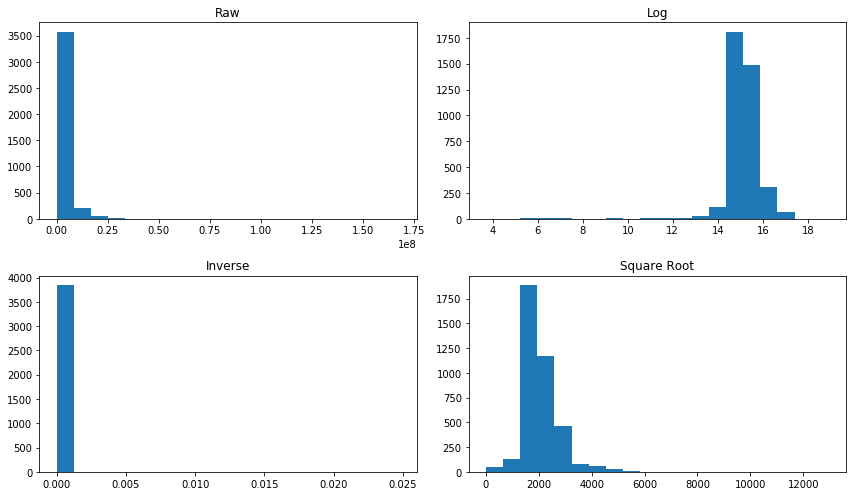

VerticalDepth


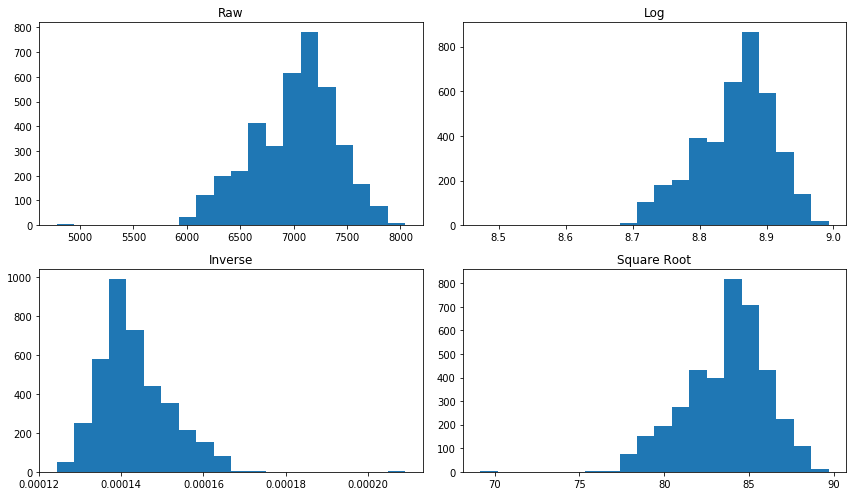

In [20]:
# Transformation to deal with non-normality
for var in ['sandmass','VerticalDepth']:
    print(var)
    plt.figure(figsize=[12,7])
    plt.subplot(221)
    plt.hist(cofracw[var].dropna(), bins=20)
    plt.title('Raw')

    plt.subplot(222)
    plt.hist(np.log(cofracw[var].dropna()), bins=20)
    plt.title('Log')

    plt.subplot(223)
    plt.hist(1/cofracw[var].dropna(), bins=20)
    plt.title('Inverse')

    plt.subplot(224)
    plt.hist(np.sqrt(cofracw[var].dropna()), bins=20)
    plt.title('Square Root')

    plt.tight_layout()
    plt.show()

The __square root of sand mass__ looks most normally distributed, and after looking into the outliers, those are accurate data points, meaning some operators actually used that much sand.

The __raw vertical depth__ distribution actually looks most normal, so I will continue with that. 

After investigating the source data for the extreme outlier for sand mass, it is a true value of the amount of sand used in a well, but I want to see what the distribution would look like without it on the plot.  I also want to see what the linear and quadratic regression lines would look like.

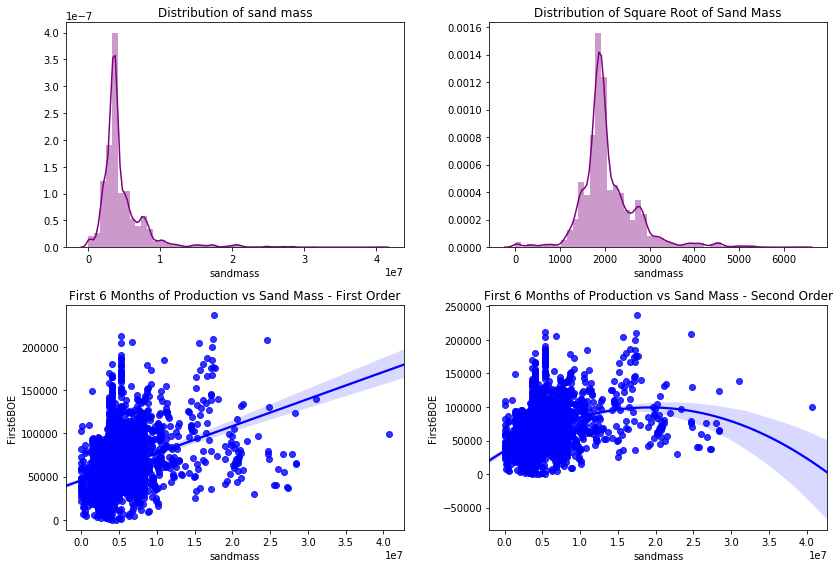

Linear R-squared: 0.1258002417870284
Quadratic R-squared: 0.14348871177787592


In [21]:
# Plotting distribution of sand mass
plt.figure(figsize=(12,8))
plt.subplot(221)
temp = cofracw[['sandmass', 'First6BOE']]
temp = temp[temp['sandmass'] < 0.5e8]
sns.distplot(temp.sandmass.dropna(axis=0), color='Purple')
plt.title('Distribution of sand mass')

plt.subplot(222)
sns.distplot(np.sqrt(temp.sandmass.dropna(axis=0)), color='Purple')
plt.title('Distribution of Square Root of Sand Mass')

# Plotting scatter plot of sand mass by production
plt.subplot(223)
sns.regplot(x=temp.sandmass, y=temp.First6BOE, color='Blue', order=1)
plt.title('First 6 Months of Production vs Sand Mass - First Order')

plt.subplot(224)
sns.regplot(x=temp.sandmass, y=temp.First6BOE, color='Blue', order=2)
plt.title('First 6 Months of Production vs Sand Mass - Second Order')

plt.tight_layout()
plt.show()

m, b, r, p, se = linregress(temp.sandmass, temp.First6BOE)
print('Linear R-squared:', r**2)
m, b, r, p, se = linregress(np.sqrt(temp.sandmass), temp.First6BOE)
print('Quadratic R-squared:', r**2)

This square root transformation definitely looks most normal, and the quadratic regression curve has a higher R-squared value than the linear relationship, so I will definitely keep the square root of sand mass as a feature. I will also drop the extreme outlier of sand mass.

In [22]:
# Creating square root of sand mass feature
cofracw['sqrtsandmass'] = np.sqrt(cofracw['sandmass'])
# Eliminating extreme sand mass outlier
cofracw = cofracw[cofracw.sandmass < 0.5e8]

### Independence between Variables
Next, I want to check out the independence between the various variables to determine the overlap of information.

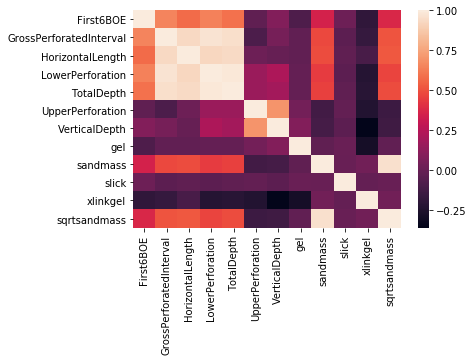

In [23]:
corrmat = cofracw.corr()
sns.heatmap(corrmat)
plt.show()

Because the gross perforated interval, horizontal length, lower perforation and total depth are all highly correlated with one another, I will need to decide which variables to keep and/or engineer and which to remove.  

Current rationale:
- Total depth represents the horizontal length plus the vertical depth, both of which are important decision points for well operators.  For this reason, I will __drop total depth__.
- Upper and Lower Perforations, along with the gross perforated interval all, in theory, should be related to one another. I want to see if I can __engineer the non-perforated horizontal length ( $HorizontalLength - GrossPerforatedInterval$ )__ to get more information from those, without having to drop too much information.  I will also __drop upper and lower perforations__.
- Knowing the data, I will also have to __impute some of the gross perforated intervals__, so I will see how those compare to horizontal length to possibly impute from that.

In [24]:
# Dropping total depth, lower and upper perforations
cofracw = cofracw.drop(['TotalDepth', 'LowerPerforation', 'UpperPerforation'], axis=1)
cofracw = cofracw.dropna(subset=['VerticalDepth'], axis=0)

### Horizontal Length and Grosss Perforated Interval
Now because gross perforated interval and horizontal length were highly correlated, I want to check the relationship between the two to see if these are linearly related so I can potentially use that relationship to impute the missing gross perforated interval values. 

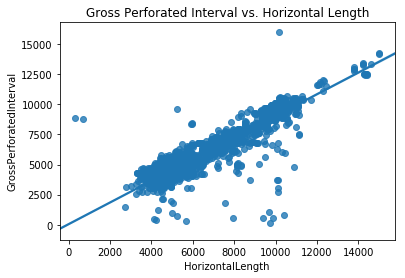

Slope: 0.9742595569413872
Intercept: 711.3033745388957
R-squared: 0.8765163457692479


In [25]:
# Graphing Gross perforated interval versus horizontal length
temp = cofrac[['GrossPerforatedInterval', 'HorizontalLength']].dropna()
sns.regplot(y=temp.GrossPerforatedInterval, x=temp.HorizontalLength)
plt.title('Gross Perforated Interval vs. Horizontal Length')
plt.show()

m, b, r, p, se = linregress(temp.GrossPerforatedInterval, temp.HorizontalLength)
print('Slope: {}\nIntercept: {}\nR-squared: {}'.format(m,b, r**2))

Based on this analysis, the gross perforated interval is 0.97 times as large as the horizontal length.  This is a pretty tight correlation because the R-squared value is 0.94 and the p-value is 0.0.  For this reason, I will impute missing gross perforated intervals by multiplying 0.97 times the horizontal length.  I also want to check out the horizontal lengths that are nearly zero to see if they were errors on entry or what happened in those situations. 

In [26]:
# Identifying all wells with less than 2000 ft of horizontal distance
cofracw[cofracw['HorizontalLength']<2000]

,First6BOE,Field,GrossPerforatedInterval,HorizontalLength,TargetFormation,VerticalDepth,gel,sandmass,slick,xlinkgel,sqrtsandmass
5123334110000,22612.0,WATTENBERG,NaN,1468.71,NIOBRARA,6206.14,0.0,1.885194e+06,1.0,1.0,1373.023506
5123352140000,21574.0,WATTENBERG,NaN,449.48,NIOBRARA,6822.48,0.0,3.436077e+06,1.0,1.0,1853.665709
5123353220000,10423.0,WATTENBERG,NaN,1065.08,NIOBRARA,6639.53,0.0,3.971200e+06,1.0,1.0,1992.787074
5123357450000,33934.0,WATTENBERG,NaN,1140.65,NIOBRARA,6334.10,0.0,1.834557e+06,1.0,1.0,1354.458377
5123359820000,58316.0,WATTENBERG,NaN,353.40,CODELL,7282.87,0.0,3.083189e+06,1.0,1.0,1755.901073
5123362450000,85233.0,WATTENBERG,NaN,455.20,NIOBRARA,6786.77,0.0,5.054498e+06,1.0,1.0,2248.221169
5123368530000,66749.0,WATTENBERG,NaN,581.65,NIOBRARA,7161.65,0.0,2.848089e+06,1.0,1.0,1687.628150
5123371080000,50732.0,WATTENBERG,NaN,1138.31,NIOBRARA,6438.02,0.0,5.361970e+06,1.0,1.0,2315.592710
5123377010000,40039.0,WATTENBERG,NaN,580.88,CODELL,6713.74,0.0,2.623372e+06,1.0,1.0,1619.682576
5123377180000,15782.0,WATTENBERG,NaN,1635.49,NIOBRARA,7119.00,0.0,2.247009e+06,1.0,1.0,1499.002516


Inconsistencies I see between COGIS database and this data...and more.
- 5123417840000 VD should be 6394. Horizontal length should be 9550
- 5123417870000 VD should be 6449.  Horizontal length should be 9578
- 5123334110000 Hz Length should be 4262 and GPI should be 3767

Knowing that a horizontal length of less than 2000 is unrealistic for a horizontal well, and after checking some of these entries, it appears that the data in the data frame does not match that in the original database.  Some of these wells had separate completions, which have apparently  gotten lost in the data extraction.  Because these encompass less than 1% of the data, I will drop these wells from our analysis.

In [27]:
todrop = cofracw[cofracw['HorizontalLength']<2000].index
cofracw = cofracw.drop(todrop, axis=0)

Great, now I want to impute gross perforated intervals for missing data before engineering another variable using those values.  The equation I will use comes from the linear relationship between gross perforated interval and horizontal length, which is: $ GPI = HZlength * 0.9743 + 711.3 $

In [28]:
# Calculating predicted values for Gross Perforated Interval
cofracw['GPIpred'] = cofracw.HorizontalLength*0.9742595569413872 + 711.3033745388957

# Filling all NAs with 0 for imputing
cofracw2 = cofracw.fillna(0)

# Imputing
for idx in cofracw2.index:
    if cofracw2.GrossPerforatedInterval[idx] > 0:
        pass
    else:
        cofracw2.GrossPerforatedInterval[idx] = cofracw2['GPIpred'][idx]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


#### Feature Engineering - Non-perforated Horizontal Feet
Knowing that there is a relationship between horizontal feet and gross perforation interval, I want to capture the information that is in the difference between the two values.  To capture this, I will calculate the non-perforated feet. 

In [29]:
# Calculating non-perforated horizontal feet
nonperfhzft = cofracw2.HorizontalLength - cofracw2.GrossPerforatedInterval

# Comparison testing between distributions of non-perforated feet and production 
spearmanr(nonperfhzft, cofracw2['First6BOE'])

SpearmanrResult(correlation=0.05389050783606723, pvalue=0.0008445523308493664)

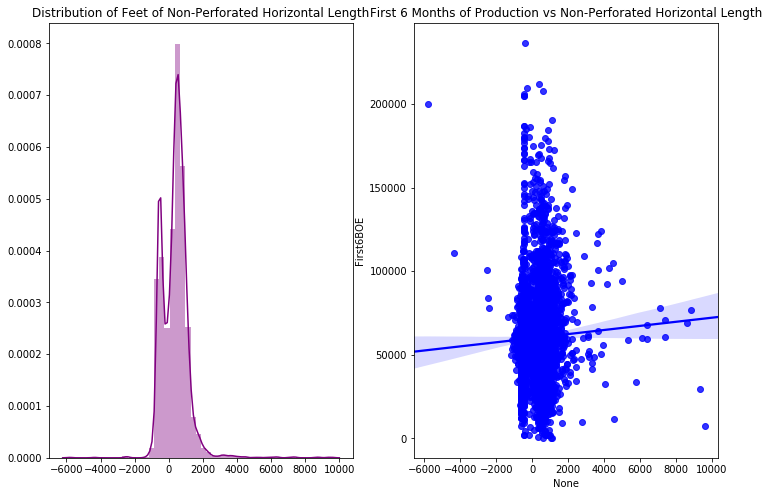

count    3833.000000
mean      371.864606
std       797.051036
min     -5800.430000
25%      -175.140000
50%       424.470000
75%       757.920000
max      9589.510000
dtype: float64

In [30]:
# Graphing Distrubtion of non-perforated feet and its relationship to production
plt.figure(figsize=(12,8))
plt.subplot(121) 
sns.distplot(nonperfhzft, color='Purple')
plt.title('Distribution of Feet of Non-Perforated Horizontal Length')

plt.subplot(122)
sns.regplot(x=nonperfhzft, y=cofracw2.First6BOE, color='Blue', order=1)
plt.title('First 6 Months of Production vs Non-Perforated Horizontal Length')
plt.show()
nonperfhzft.describe()

This looks like the non-perforated feet is a bimodal distribution, with the split at zero.  Gross perforated feet over horizontal length means that the operator fraced the vertical section of the well in addition to the horizontal section, whereas a positive value of non-perforated horizontal feet means that the operator only fraced a portion of the horizontal length.  Because of this bimodal distribution, I will try some transformations to create a more normal distribution, but I also might try to binarize this variable into only-horizontal frac versus horizontal and vertical fracing.

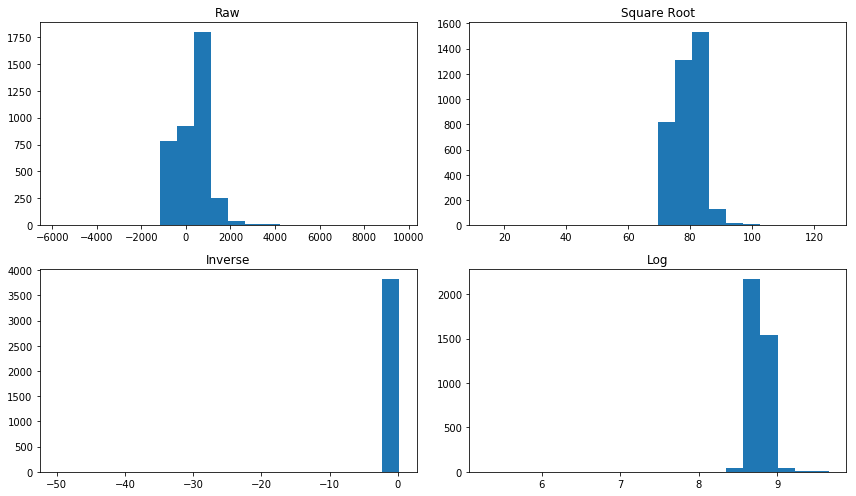

In [31]:
# Transformations for non-normality
plt.figure(figsize=[12,7])
plt.subplot(221)
plt.hist(nonperfhzft, bins=20)
plt.title('Raw')

plt.subplot(222)
plt.hist(np.sqrt(nonperfhzft+6000), bins=20)
plt.title('Square Root')

plt.subplot(223)
plt.hist(1/nonperfhzft, bins=20)
plt.title('Inverse')

plt.subplot(224)
plt.hist(np.log(nonperfhzft+6000), bins=20)
plt.title('Log')

plt.tight_layout()
plt.show()

The square root transformation looks most normal, but I had to add a value of 6000 to make all of the values positive to take the square root.  I want to binarize the distribution and see how the two different transformations are related to production.

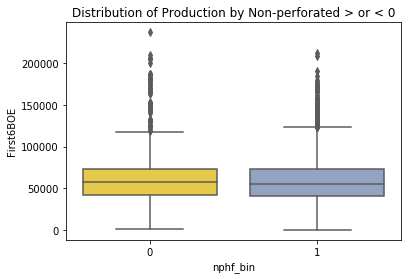

Binary Mann-Whitney U: MannwhitneyuResult(statistic=1488701.5, pvalue=0.13407022608713165)


In [32]:
# Binarizing non-perforated horizontal feet
cofracw2['nphf_bin'] = nonperfhzft.map(lambda x: 0 if x <=0 else 1)

# Plotting distribtion of binary feature
sns.boxplot(y='First6BOE', x='nphf_bin', data=cofracw2, palette='Set2_r')
plt.title('Distribution of Production by Non-perforated > or < 0')
plt.show()

print('Binary Mann-Whitney U: {}'.format(mannwhitneyu(cofracw2[cofracw2.nphf_bin==0]['First6BOE'], 
                                                                         cofracw2[cofracw2.nphf_bin==1]['First6BOE'])))

Well, according to the p-values for the distributions, I should not keep the binary version of non-perforated feet, but I should keep the square root version.  Because of the need to turn this into a positive value, this essentially becomes non-perforated feet. 

In [33]:
cofracw2['nphf_sqrt'] = np.sqrt(nonperfhzft+6000)

#### Feature Engineering - Binned Horizontal Length
As mentioned earlier, I will bin the horizontal feet to eliminate the trimodal distribution.

In [47]:
# Creating bins for the three general horizontal legnths
for idx in cofracw2.index:
    if cofracw2.loc[idx, 'HorizontalLength'] <= 6000:
        cofracw2.loc[idx, 'hzlen_bin'] = '<1'
    elif cofracw2.loc[idx, 'HorizontalLength'] > 8500:
        cofracw2.loc[idx, 'hzlen_bin'] = '>2'
    else:
        cofracw2.loc[idx, 'hzlen_bin'] = '1-2'

Now, let's check for the distribution of wells in these bins.

In [48]:
cofracw2.hzlen_bin.value_counts()

<1     2419
>2      804
1-2     610
Name: hzlen_bin, dtype: int64

Wells mostly fall within one mile of vertical, but a good number are around two miles, and a slightly smaller number are between one and two miles in horizontal length.

Now, I want to check to see how the bins are related to production in the first six months after fracing.

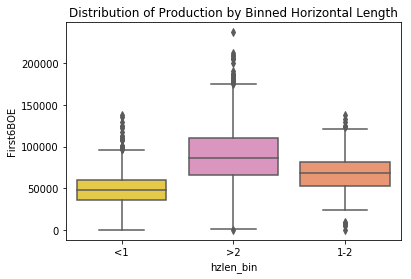

In [49]:
# Plotting distribtion of binary feature
sns.boxplot(y='First6BOE', x='hzlen_bin', data=cofracw2, palette='Set2_r')
plt.title('Distribution of Production by Binned Horizontal Length')
plt.show()

Wow, this definitely looks like the longer the horizontal length, the greater the production.  I will check this difference through the Kruskal test for the three distributions. If the p-value of this test is significant at an alpha of 0.05, then there is a difference in the distributions.

In [50]:
print('Binned Kruskal: {}'.format(kruskal(cofracw2[cofracw2.hzlen_bin=='<1']['First6BOE'], 
                                            cofracw2[cofracw2.hzlen_bin=='1-2']['First6BOE'],
                                         cofracw2[cofracw2.hzlen_bin=='>2']['First6BOE'])))

Binned Kruskal: KruskalResult(statistic=1124.7626813074135, pvalue=5.76616450989152e-245)


Based on the p-value from the Kruskal test, there is a significant difference between the production of the bins.  This does not give us information about which are different, so I will calculate the Mann Whitney U test for each pair.

In [51]:
print('<1 vs 1-2', mannwhitneyu(cofracw2[cofracw2['hzlen_bin']=='<1']['First6BOE'], 
                             cofracw2[cofracw2['hzlen_bin']=='1-2']['First6BOE']))
print('<1 vs >2', mannwhitneyu(cofracw2[cofracw2['hzlen_bin']=='<1']['First6BOE'], 
                             cofracw2[cofracw2['hzlen_bin']=='>2']['First6BOE']))
print('1-2 vs >2', mannwhitneyu(cofracw2[cofracw2['hzlen_bin']=='1-2']['First6BOE'], 
                             cofracw2[cofracw2['hzlen_bin']=='>2']['First6BOE']))

<1 vs 1-2 MannwhitneyuResult(statistic=343055.0, pvalue=2.992952897173138e-93)
<1 vs >2 MannwhitneyuResult(statistic=289042.5, pvalue=1.0957209200382177e-196)
1-2 vs >2 MannwhitneyuResult(statistic=154445.5, pvalue=3.813522566968487e-33)


Based on the Mann Whitney U Test, all of the bins of horizontal length have significant differences in production.  I will definitely keep this as a feature in our modeling.

### Gathering Features for Modeling
Based on the above analysis, the following are features that I will use to predict the production from the first six months of the well:
- Types of Fracing: Gel, Slickwater and Cross-linked Gel
- Drilling Characteristics: Target Formation, Vertical Depth, Horizontal Length (binned), and Non-perforated length (square root)
- Frac Characteristic: Sand mass (square root)


In [52]:
# Selecting out relevant features for modeling
cofeatures = cofracw2[['gel','slick','xlinkgel',
                       'TargetFormation','VerticalDepth','hzlen_bin','nphf_sqrt','sqrtsandmass',
                       'First6BOE']]
cofeatures.head()

,gel,slick,xlinkgel,TargetFormation,VerticalDepth,hzlen_bin,nphf_sqrt,sqrtsandmass,First6BOE
5001098010000,0.0,1.0,1.0,CODELL,7774.00,<1,73.120155,1591.816874,46241.0
5001097820000,0.0,1.0,1.0,NIOBRARA,7574.72,<1,73.519946,1668.595385,7118.0
5001098410000,0.0,0.0,0.0,CODELL,8045.00,<1,73.509025,1772.463745,23404.0
5001098450000,0.0,1.0,0.0,CODELL,7841.00,<1,73.543258,1999.739152,97243.0
5001098470000,0.0,1.0,0.0,CODELL,7707.00,<1,73.740393,1984.574673,93034.0


Now, just a final check that our features are independent, let's check out the heatmap for the features.

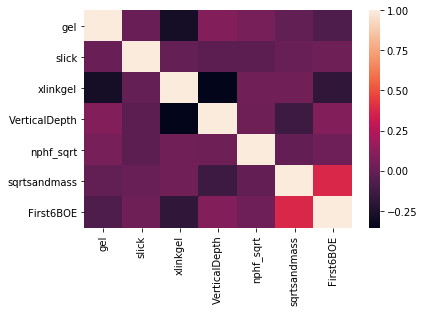

In [53]:
corrmat = cofeatures.corr()
sns.heatmap(corrmat)
plt.show()

Great, looks like the features are all independent from each other.  Finally, to prepare for modeling, I will get dummy variables for the target formations and horizontal lengths

In [54]:
cofeatures = pd.get_dummies(cofeatures)
cofeatures.head()

,gel,slick,xlinkgel,VerticalDepth,nphf_sqrt,sqrtsandmass,First6BOE,TargetFormation_CODELL,TargetFormation_NIOBRARA,TargetFormation_OTHER,hzlen_bin_1-2,hzlen_bin_<1,hzlen_bin_>2
5001098010000,0.0,1.0,1.0,7774.00,73.120155,1591.816874,46241.0,1,0,0,0,1,0
5001097820000,0.0,1.0,1.0,7574.72,73.519946,1668.595385,7118.0,0,1,0,0,1,0
5001098410000,0.0,0.0,0.0,8045.00,73.509025,1772.463745,23404.0,1,0,0,0,1,0
5001098450000,0.0,1.0,0.0,7841.00,73.543258,1999.739152,97243.0,1,0,0,0,1,0
5001098470000,0.0,1.0,0.0,7707.00,73.740393,1984.574673,93034.0,1,0,0,0,1,0


These look great. 

Writing features to csv for modeling.

In [55]:
cofeatures.to_csv('cofeatures')

Potential code for adding altitude as a feature

In [43]:
#from json import loads
#from time import sleep
#from urllib2 import Request, urlopen

#locations=[(27.988056, 86.925278), (50.449561, 30.525366)] #(lat,lon) pairs
#for loc in locations: 
#    try:
#        request = Request('https://maps.googleapis.com/maps/api/elevation/json?locations={0},{1}&key=INSERT_YOUR_KEY_HERE'.format(loc[0],loc[1]))
#        response = urlopen(request).read() 
#        places = loads(response)
#        print 'At {0} elevation is: {1}'.format(loc, places['results'][0]['elevation'])
#        sleep(1)
#    except:
#        print 'Error for location: {0}'.format(loc)